# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Useful Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Create Time Series

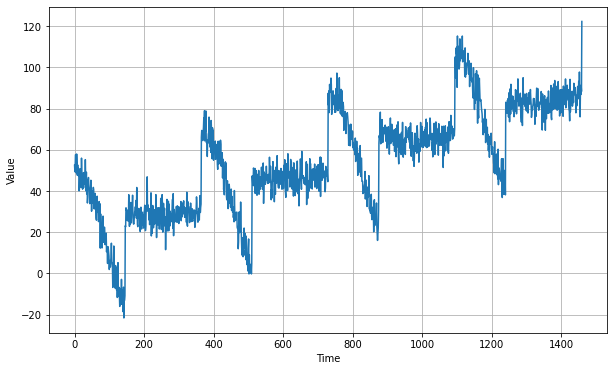

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
period = 365

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting Time Series

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Creating windowed dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

for x,y in dataset:
  print(x.numpy(), y.numpy())
  break

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
[[ 65.02451     67.588295    63.59635     71.24777     60.667767
   73.05737     63.8552      56.905815    64.7043      60.66297
   68.27628     60.815144    61.852913    54.642056    61.834522
   51.983303    56.19019     67.919136    68.053764    66.2601    ]
 [ 43.35101     41.514812    40.177532    33.871693    37.237713
   38.097908    45.242546    41.222683    30.229015    40.196377
   36.174564    34.231815    40.183838    41.78223     40.778324
   31.413605    33.544636    36.221428    38.910835    31.098982  ]
 [ 45.725693    44.566395    87.479225    81.65221     88.61756
   78.08376     91.750984    88.96491     87.86698     91.473404
   94.84867     91.54276     77.20444     79.93713     83.12551
   86.283035    88.6323      82.2952      86.72619     81.8725    ]
 [ 71.24777     60.667767    73.05737     63.8552      56.905815
   64.7043      60.66297     68.27628     60.815144    61.852913
 

# Create Model

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
  loss = 'mse',
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(dataset,
          epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 322.8350
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 161.7769
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 139.5296
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 125.3608
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 113.6401
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 103.4524
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 95.4574
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 89.5649
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 82.5242
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 77.5484
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 73.7331
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 71.6535
Epoch 13/100
31/31 

In [10]:
print("Layer weights {}".format(model.layers[0].get_weights()))

Layer weights [array([[-0.36046234, -0.20306765,  0.34554327, -0.25550407,  0.35958102,
         0.3978978 ,  0.11821823, -0.3122085 , -0.29964745,  0.03211424],
       [ 0.106018  , -0.17802674, -0.07143863, -0.34265956,  0.09557261,
        -0.11822453, -0.03022746, -0.34542364, -0.06991322, -0.04297579],
       [ 0.26207286,  0.37026367, -0.39742693, -0.02581852,  0.45823818,
        -0.33627084, -0.37926757,  0.4139077 ,  0.12206306, -0.18638712],
       [ 0.33170754,  0.04023428, -0.2255664 , -0.22301754,  0.15417778,
        -0.14949979, -0.23612964, -0.43199307, -0.03044133, -0.34389272],
       [-0.30889645,  0.07127494,  0.44354695, -0.41834638,  0.31220886,
         0.39416966,  0.38271672, -0.38920236, -0.05469506,  0.00479369],
       [-0.02131869, -0.4440184 , -0.33853167, -0.20864396,  0.4258698 ,
        -0.2660591 ,  0.33808848,  0.03883759, -0.17403677, -0.14096709],
       [-0.05777846,  0.18823506, -0.31387323, -0.05036902,  0.20065846,
        -0.14669152, -0.184309

# Predict series using model

In [11]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


print(len(results))

461


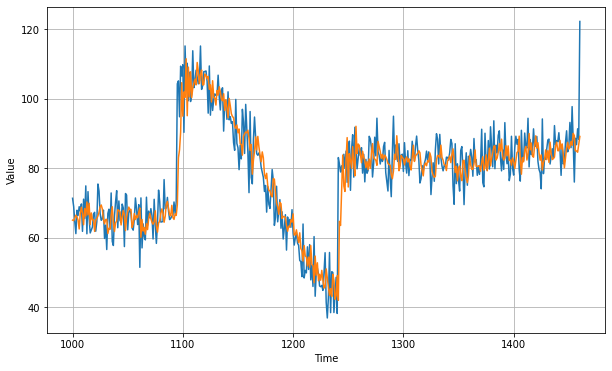

In [12]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

# Loss

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.985605

# Find out Learning Rate

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
  loss = 'mse',
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
)

model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10** (epoch/20)
)
history = model.fit(dataset,
          epochs=100,
          callbacks=[lr_schedule])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 659.7208
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 467.1573
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 324.8277
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 239.1614
Epoch 5/100
31/31 [==============================] - 0s 2m

(1e-08, 0.001, 0.0, 300.0)

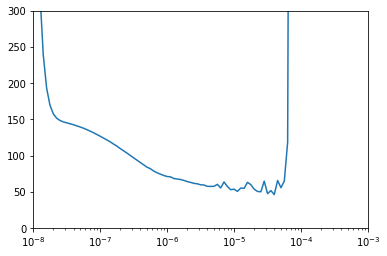

In [15]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

# Train model again with better learning rate

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
  loss = 'mse',
  optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
)

model.summary()

history = model.fit(dataset,
          epochs=500)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 0s 2ms/step - loss: 290.2753
Epoch 2/500
31/31 [==============================] - 0s 2ms/step - loss: 72.2576
Epoch 3/500
31/31 [==============================] - 0s 2ms/step - loss: 63.5927
Epoch 4/500
31/31 [==============================] - 0s 2ms/step - loss: 61.1534
Epoch 5/500
31/31 [==============================] - 0s 2ms/s

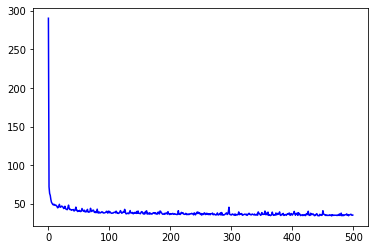

In [17]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[48.535560607910156, 48.29582595825195, 48.75736618041992, 47.61654281616211, 47.09659957885742, 45.08380126953125, 45.448951721191406, 47.386314392089844, 49.58890151977539, 46.0300407409668, 45.823280334472656, 46.90559005737305, 47.308929443359375, 46.3746452331543, 46.07022476196289, 44.101112365722656, 44.526695251464844, 47.02474594116211, 44.623722076416016, 43.12351608276367, 42.93038558959961, 42.67174530029297, 45.87606430053711, 48.515953063964844, 44.562644958496094, 42.86626434326172, 43.10176467895508, 42.48689651489258, 41.85622024536133, 42.4813232421875, 42.64914321899414, 42.788143157958984, 40.91865539550781, 41.431251525878906, 42.913028717041016, 45.93444061279297, 41.542903900146484, 42.055381774902344, 40.203369140625, 41.20680236816406, 40.82734298706055, 41.72575378417969, 40.3624153137207, 40.245216369628906, 40.74363708496094, 44.16309356689453, 42.389434814453125, 40.96177291870117, 40.4892578125, 41.943275451660156, 39.82454299926758, 40.41847229003906, 39.

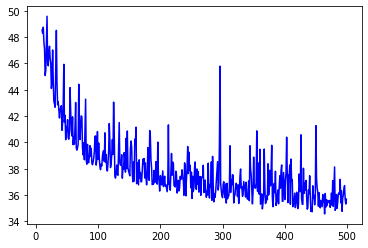

In [18]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))

plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


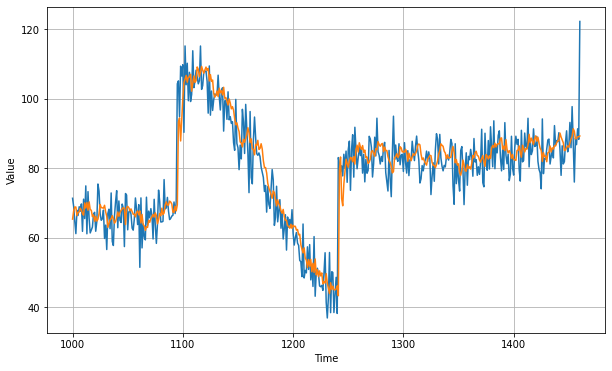

In [20]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8653474